# Analyze meta teacher

In [1]:
import warnings
warnings.filterwarnings("ignore")

import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import umap

from lift.environments.gym_envs import NpGymEnv
from lift.environments.teacher_envs import TeacherEnv
from lift.environments.rollout import rollout

from lift.teacher import load_teacher
from configs import BaseConfig

In [2]:
config = BaseConfig()

teacher = load_teacher(config, meta=True)


MetaSAC teacher loaded


In [3]:
# class ConditionedTeacher:
#     def __init__(self, teacher, noise=0., alpha=0.):
#         self.noise = noise
#         self.alpha = alpha
#         self.teacher = teacher

#     def sample_action(self, obs, sample_mean):
#         # NOTE: be careful about meta var indexing in case teacher is not trained on alpha
#         obs_ = copy.deepcopy(obs)
#         obs_["observation"][..., -2] = self.noise
#         obs_["observation"][..., -1] = self.alpha
#         return self.teacher.sample_action(obs_, sample_mean)
from lift.environments.teacher_envs import ConditionedTeacher

In [15]:
# generate traj
def eval_teacher(teacher, noise, alpha, teacher_noise, teacher_alpha, n_steps=3000):
    env_noise_range = [noise, noise]
    # alpha_range = [alpha, alpha]
    env = NpGymEnv("FetchReachDense-v2", max_episode_steps=100)
    env = TeacherEnv(env, env_noise_range, noise_slope=0.)

    conditioned_teacher = ConditionedTeacher(
        teacher, noise_range=[teacher_noise, teacher_noise], alpha_range=[teacher_alpha, teacher_alpha],
    )
    conditioned_teacher.reset()
    
    data = rollout(
        env,
        conditioned_teacher,
        n_steps=n_steps,
        terminate_on_done=False,
        reset_on_done=True,
        random_pertube_prob=0.,
        action_noise=0.,
    )
    return data

In [5]:
# def query_teacher_conditioned(obs, noise, alpha, num_samples=100):
#     obs_ = obs.clone()
#     obs_[..., -2] = noise
#     obs_[..., -1] = alpha
#     teacher_inputs = TensorDict({"observation": obs_})
#     dist = teacher.model.policy.get_dist(teacher_inputs)

#     act_mean = dist.mode
#     act_std = dist.sample((num_samples,)).std(0)
#     return act_mean, act_std

In [16]:
# eval teacher with different meta variables in the same environment
np.random.seed(0)

noise = 0.
alpha = 0.

num_rows = 10
num_cols = 10
teacher_noises = torch.linspace(0.001, 1., steps=num_rows)
teacher_alphas = torch.linspace(0.01, 1., steps=num_cols)

eval_data_1 = [[None for _ in range(num_cols)] for _ in range(num_rows)]
for i, teacher_noise in enumerate(teacher_noises):
    for j, teacher_alpha in enumerate(teacher_alphas):
        eval_data_1[i][j] = eval_teacher(
            teacher,
            noise, 
            alpha,
            teacher_noise,
            teacher_alpha,
        )

Rollout: 100%|██████████| 3000/3000 [00:05<00:00, 588.16item/s]


In [17]:
# eval teacher with different meta variables in the same environment
np.random.seed(0)

noise = 1.
alpha = 0.

num_rows = 10
num_cols = 10
teacher_noises = torch.linspace(0.001, 1., steps=num_rows)
teacher_alphas = torch.linspace(0.01, 1., steps=num_cols)

eval_data_2 = [[None for _ in range(num_cols)] for _ in range(num_rows)]
for i, teacher_noise in enumerate(teacher_noises):
    for j, teacher_alpha in enumerate(teacher_alphas):
        eval_data_2[i][j] = eval_teacher(
            teacher,
            noise, 
            alpha,
            teacher_noise,
            teacher_alpha,
        )

Rollout: 100%|██████████| 3000/3000 [00:04<00:00, 749.30item/s]


In [27]:
# compute aggregate stats
def compute_stats(eval_data, func):
    num_rows = len(eval_data)
    num_cols = len(eval_data[0])
    return np.array([[func(eval_data[i][j]) for j in range(num_cols)] for i in range(num_rows)])

def compute_mean_reward(data):
    return data["rwd"].mean()

def compute_cum_reward(data):
    return data["rwd"].sum() / data["done"].sum()

def compute_reward_std(data):
    return data["rwd"].std()

def compute_eps_len(data):
    return len(data["done"]) / data["done"].sum()

def compute_act_abs(data):
    return np.abs(data["act"]).mean()

def compute_act_mean(data):
    return data["act"].mean()

def compute_act_std(data):
    return data["act"].std()

eval_rwd_mean_1 = compute_stats(eval_data_1, compute_mean_reward)
eval_rwd_std_1 = compute_stats(eval_data_1, compute_reward_std)
eval_act_mean_1 = compute_stats(eval_data_1, compute_act_mean)
eval_act_std_1 = compute_stats(eval_data_1, compute_act_std)
eval_act_abs_1 = compute_stats(eval_data_1, compute_act_abs)

eval_rwd_mean_2 = compute_stats(eval_data_2, compute_mean_reward)
eval_rwd_std_2 = compute_stats(eval_data_2, compute_reward_std)
eval_act_mean_2 = compute_stats(eval_data_2, compute_act_mean)
eval_act_std_2 = compute_stats(eval_data_2, compute_act_std)
eval_act_abs_2 = compute_stats(eval_data_2, compute_act_abs)

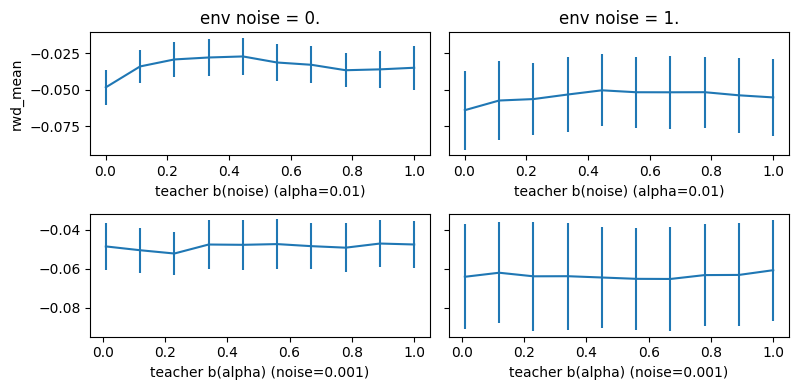

In [28]:
# compare reward
fig, ax = plt.subplots(2, 2, figsize=(8, 4), sharey="row")

alpha_ref_idx = 0
noise_ref_idx = 0

ax[0,0].errorbar(
    teacher_noises, 
    eval_rwd_mean_1[:,alpha_ref_idx].flatten(), 
    yerr=eval_rwd_std_1[:,alpha_ref_idx].flatten()
)

ax[0,1].errorbar(
    teacher_noises, 
    eval_rwd_mean_2[:,alpha_ref_idx].flatten(), 
    yerr=eval_rwd_std_2[:,alpha_ref_idx].flatten()
)

ax[1,0].errorbar(
    teacher_alphas, 
    eval_rwd_mean_1[noise_ref_idx,:].flatten(), 
    yerr=eval_rwd_std_1[noise_ref_idx,:].flatten()
)

ax[1,1].errorbar(
    teacher_alphas, 
    eval_rwd_mean_2[noise_ref_idx,:].flatten(), 
    yerr=eval_rwd_std_2[noise_ref_idx,:].flatten()
)

ax[0,0].set_xlabel(f"teacher b(noise) (alpha={teacher_alphas[alpha_ref_idx]:.2f})")
ax[0,0].set_ylabel("rwd_mean")
ax[0,0].set_title("env noise = 0.")

ax[0,1].set_xlabel(f"teacher b(noise) (alpha={teacher_alphas[alpha_ref_idx]:.2f})")
ax[0,1].set_title("env noise = 1.")

ax[1,0].set_xlabel(f"teacher b(alpha) (noise={teacher_noises[noise_ref_idx]:.3f})")
ax[1,1].set_xlabel(f"teacher b(alpha) (noise={teacher_noises[noise_ref_idx]:.3f})")

plt.tight_layout()
plt.show()

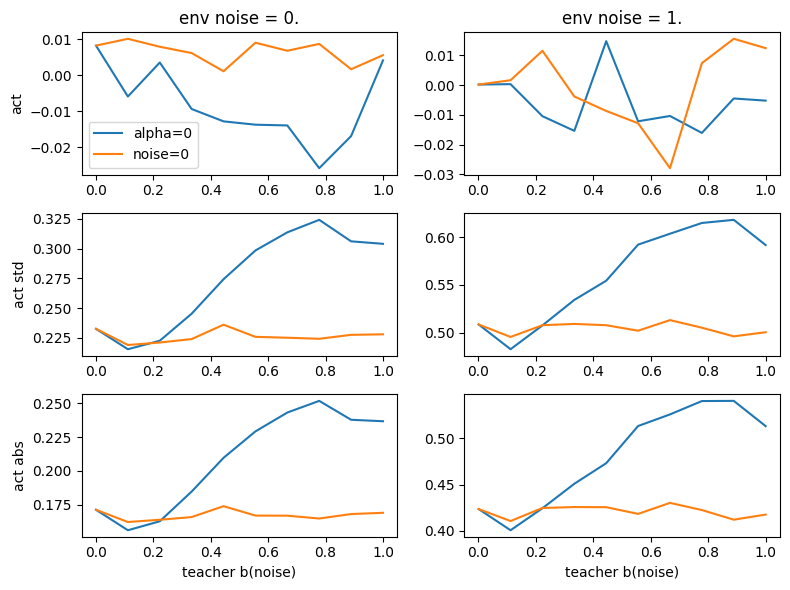

In [29]:
# compare actions
fig, ax = plt.subplots(3, 2, figsize=(8, 6), sharex="row")
ax[0, 0].plot(teacher_noises, eval_act_mean_1[:,0].flatten(), label="alpha=0")
ax[0, 0].plot(teacher_noises, eval_act_mean_1[0,:].flatten(), label="noise=0")

ax[0, 1].plot(teacher_noises, eval_act_mean_2[:,0].flatten(), label="alpha=0")
ax[0, 1].plot(teacher_noises, eval_act_mean_2[0,:].flatten(), label="noise=0")

ax[1, 0].plot(teacher_noises, eval_act_std_1[:,0].flatten(), label="alpha=0")
ax[1, 0].plot(teacher_noises, eval_act_std_1[0,:].flatten(), label="noise=0")

ax[1, 1].plot(teacher_noises, eval_act_std_2[:,0].flatten(), label="alpha=0")
ax[1, 1].plot(teacher_noises, eval_act_std_2[0,:].flatten(), label="noise=0")

ax[2, 0].plot(teacher_noises, eval_act_abs_1[:,0].flatten(), label="alpha=0")
ax[2, 0].plot(teacher_noises, eval_act_abs_1[0,:].flatten(), label="noise=0")

ax[2, 1].plot(teacher_noises, eval_act_abs_2[:,0].flatten(), label="alpha=0")
ax[2, 1].plot(teacher_noises, eval_act_abs_2[0,:].flatten(), label="noise=0")

ax[0, 0].set_title("env noise = 0.")
ax[0, 1].set_title("env noise = 1.")

ax[-1, 0].set_xlabel("teacher b(noise)")
ax[-1, 1].set_xlabel("teacher b(noise)")

ax[0, 0].set_ylabel("act")
ax[1, 0].set_ylabel("act std")
ax[2, 0].set_ylabel("act abs")
ax[0, 0].legend()
plt.tight_layout()
plt.show()

In [32]:
# umap state distributions
def normalize(x, mu, std):
    return (x - mu) / std

state_dim = 10 # robot pose, exclude goal pose
eval_states_1 = np.vstack([eval_data_1[i][0]["obs"]["observation"][..., :state_dim] for i in range(len(eval_data_1))])
eval_states_2 = np.vstack([eval_data_2[i][0]["obs"]["observation"][..., :state_dim] for i in range(len(eval_data_2))])
eval_state_labels_1 = np.vstack([np.ones_like(eval_data_1[i][0]["obs"]["observation"][..., :1]) * float(teacher_noises[i]) for i in range(len(eval_data_1))])
eval_state_labels_2 = np.vstack([np.ones_like(eval_data_2[i][0]["obs"]["observation"][..., :1]) * float(teacher_noises[i]) for i in range(len(eval_data_2))])

eval_states = np.vstack([eval_states_1, eval_states_2])

eval_states_norm = normalize(
    eval_states,
    eval_states.mean(0),
    eval_states.std(0),
)

print("eval state size", eval_states_norm.shape)

eval state size (60000, 10)


In [33]:
reducer = umap.UMAP(
    n_neighbors=50, 
    n_components=2, 
    metric="euclidean",
    n_jobs=1,
    random_state=0,
)
embeddings = reducer.fit_transform(eval_states_norm)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [34]:
# chunk embeddings
eval_state_embeddings_1 = embeddings[:len(eval_states_1)]
eval_state_embeddings_2 = embeddings[len(eval_states_1):]

/Users/kilian/opt/miniconda3/envs/lift/lib/python3.11/site-packages/matplotlib/cbook.py:1699: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return math.isfinite(val)


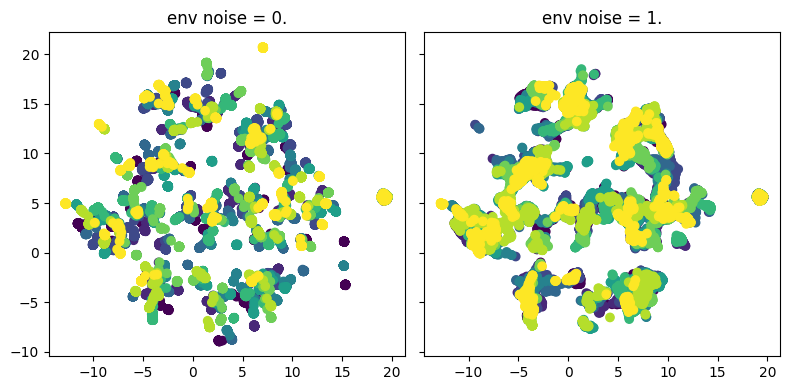

In [35]:
# plot state distributions embeddings
fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
ax[0].scatter(
    eval_state_embeddings_1[:, 0],
    eval_state_embeddings_1[:, 1],
    c=eval_state_labels_1,
)

ax[1].scatter(
    eval_state_embeddings_2[:, 0],
    eval_state_embeddings_2[:, 1],
    c=eval_state_labels_2,
)

ax[0].set_title("env noise = 0.")
ax[1].set_title("env noise = 1.")

plt.tight_layout()
plt.show()

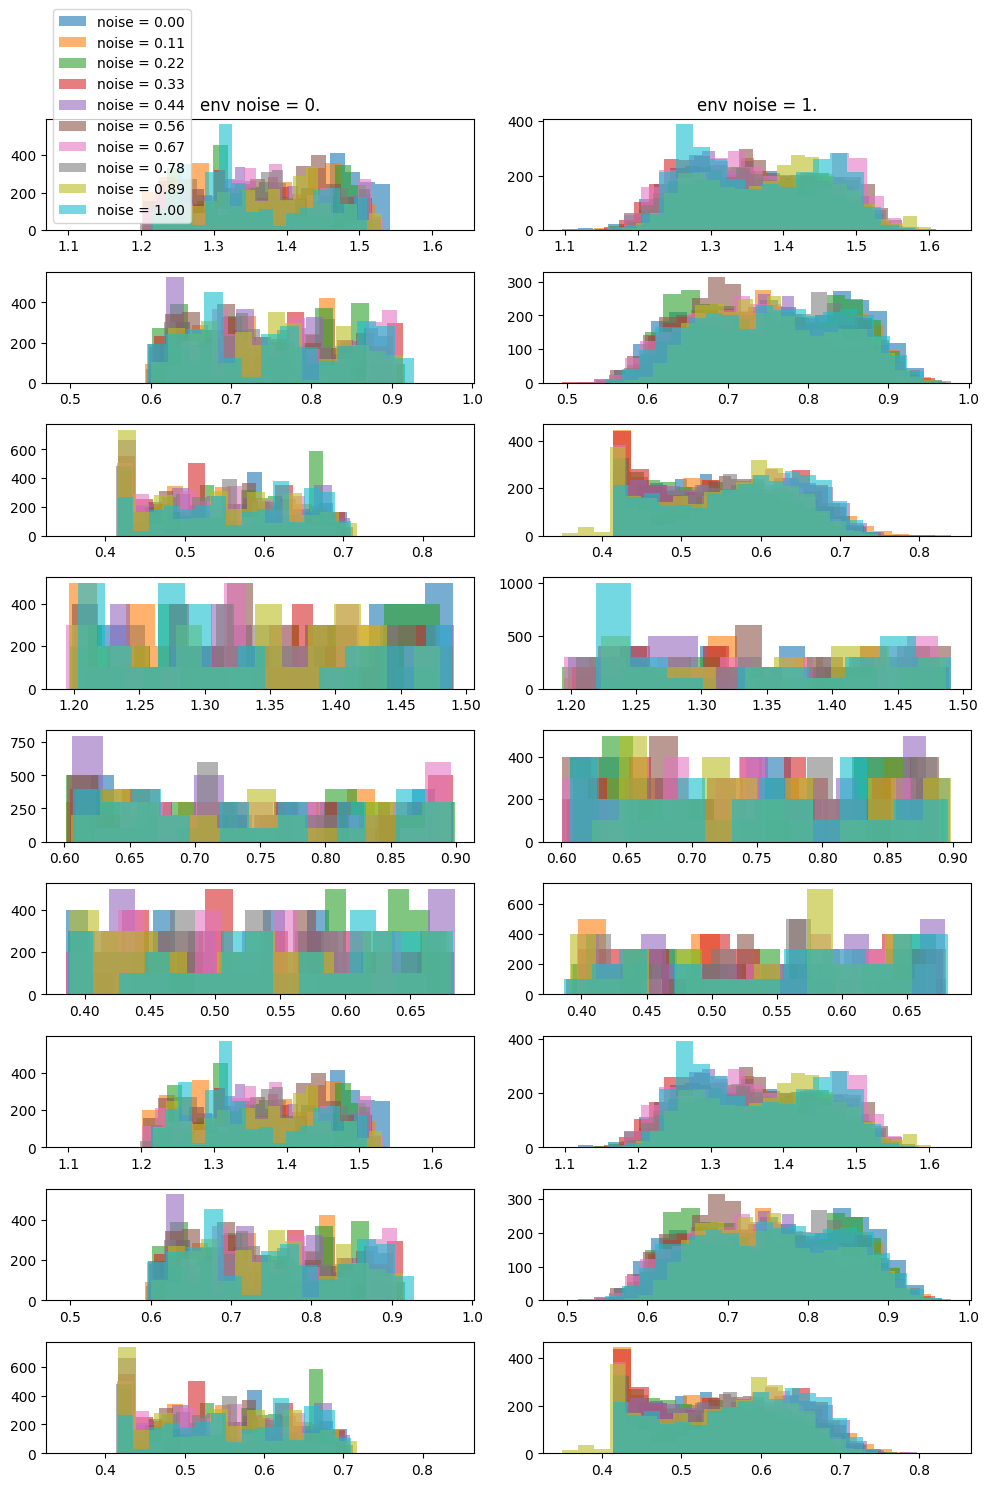

In [36]:
# plot state feature distributions
state_idxs = np.arange(state_dim - 1)
fig, ax = plt.subplots(len(state_idxs), 2, figsize=(10, 15), sharex="row")
for i, s in enumerate(state_idxs):
    for j in range(len(teacher_noises)):
        ax[i, 0].hist(eval_data_1[j][0]["obs"]["observation"][:, i], bins="fd", alpha=0.6, label="noise = {:.2f}".format(teacher_noises[j]))
        ax[i, 1].hist(eval_data_2[j][0]["obs"]["observation"][:, i], bins="fd", alpha=0.6, label="noise = {:.2f}".format(teacher_noises[j]))    
ax[0, 0].legend()
ax[0, 0].set_title("env noise = 0.")
ax[0, 1].set_title("env noise = 1.")

plt.tight_layout()
plt.show()

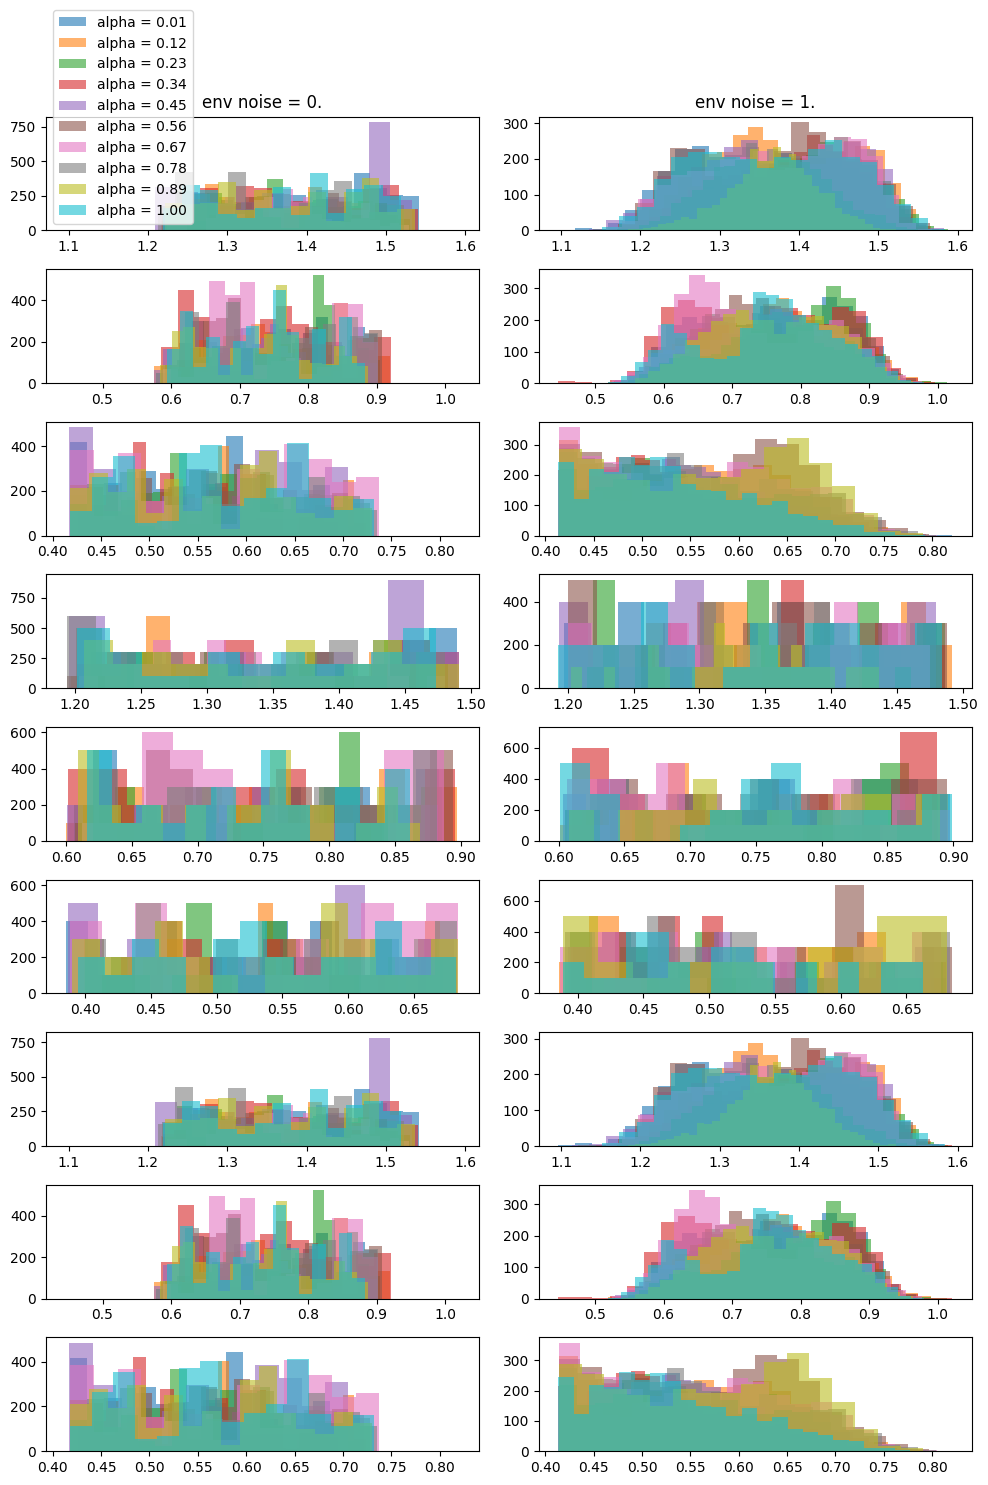

In [37]:
# plot state feature distributions
state_idxs = np.arange(state_dim - 1)
fig, ax = plt.subplots(len(state_idxs), 2, figsize=(10, 15), sharex="row")
for i, s in enumerate(state_idxs):
    for j in range(len(teacher_alphas)):
        ax[i, 0].hist(eval_data_1[0][j]["obs"]["observation"][:, i], bins="fd", alpha=0.6, label="alpha = {:.2f}".format(teacher_alphas[j]))
        ax[i, 1].hist(eval_data_2[0][j]["obs"]["observation"][:, i], bins="fd", alpha=0.6, label="alpha = {:.2f}".format(teacher_alphas[j]))    
ax[0, 0].legend()
ax[0, 0].set_title("env noise = 0.")
ax[0, 1].set_title("env noise = 1.")

plt.tight_layout()
plt.show()

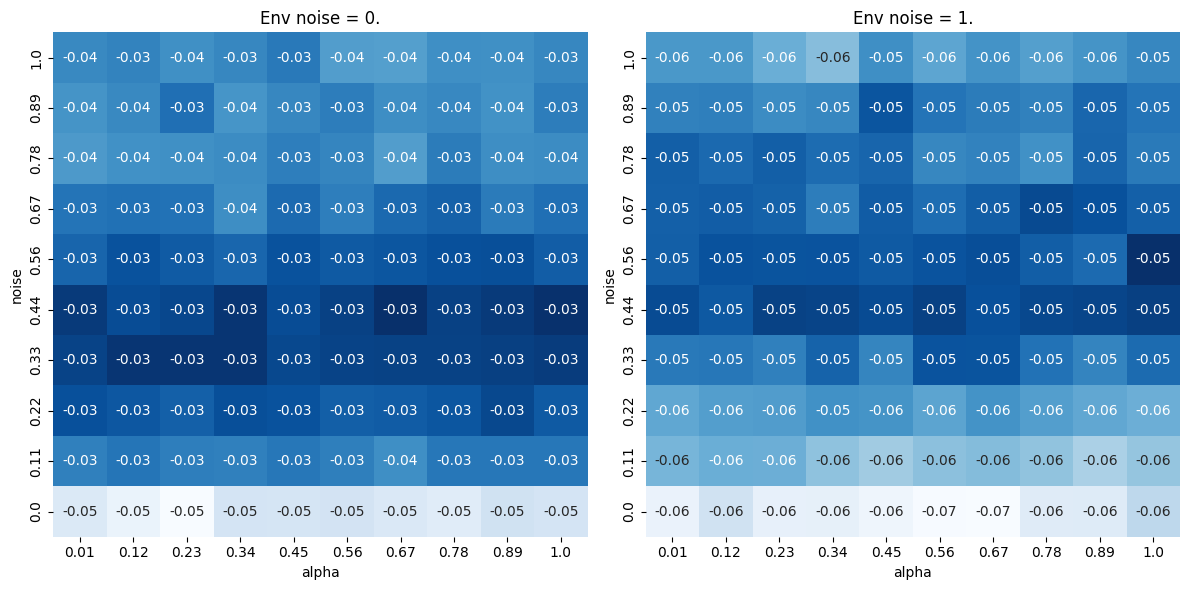

In [38]:
def plot_heat_map(eval_stats, ax, xlabel, ylabel):
    df = pd.DataFrame(
        eval_stats, 
        index=[round(i, 2) for i in teacher_noises.tolist()], 
        columns=[round(i, 2) for i in teacher_alphas.tolist()], 
    )
    sns.heatmap(df, annot=True, cbar=False, fmt=".2f", cmap="Blues", ax=ax)
    ax.invert_yaxis()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
plot_heat_map(eval_rwd_mean_1, ax[0], "alpha", "noise")
plot_heat_map(eval_rwd_mean_2, ax[1], "alpha", "noise")
ax[0].set_title("Env noise = 0.")
ax[1].set_title("Env noise = 1.")
plt.tight_layout()
plt.show()

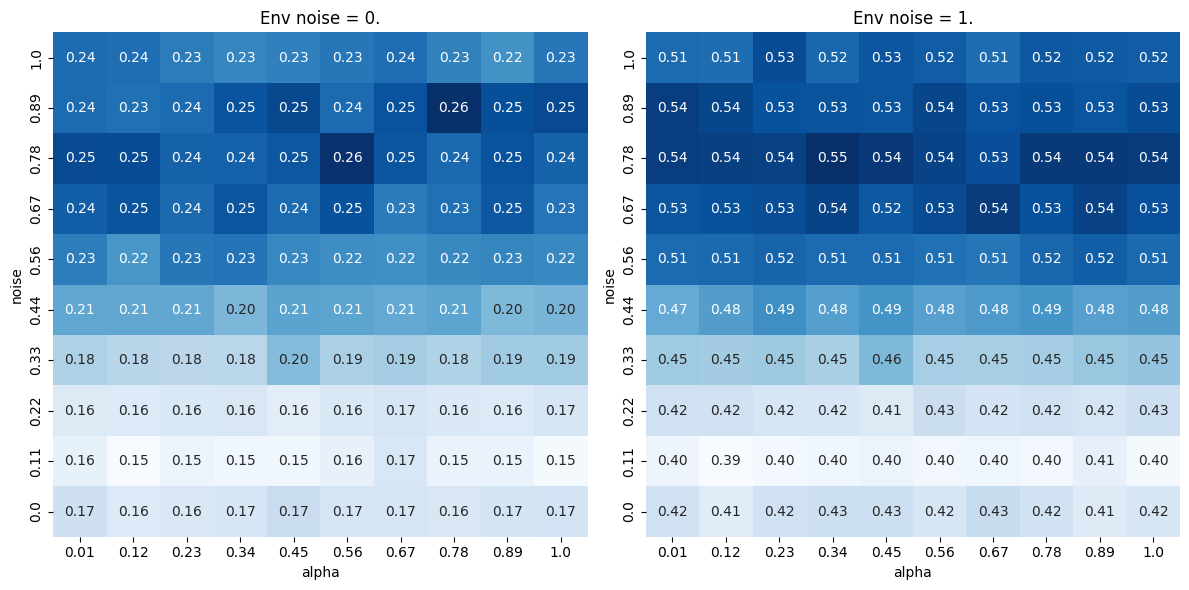

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
plot_heat_map(eval_act_abs_1, ax[0], "alpha", "noise")
plot_heat_map(eval_act_abs_2, ax[1], "alpha", "noise")
ax[0].set_title("Env noise = 0.")
ax[1].set_title("Env noise = 1.")
plt.tight_layout()
plt.show()